# ARGO Example (using an unlabelled dataset)

This notebook contains an example of how the ARGO package can be used to:

* Optimise existing rules
* Identify unnecessary rules
* Test final rule set on test data
* Generate/update the system-ready configs of the final rule set
* Update the Simility environment with the final rule set

**Currently, ARGO is unable to generate rules or scores using an unlabelled dataset.**

## Requirements

To run, you'll need the following:

* Install the ARGO package - see the readme for more information.
* A raw, unlabelled dataset.

---

## Table of contents
1. [Read/process data](#ReadProcessData)
2. [Rule Optimisation](#RuleOptimisation)
3. [Identify unnecessary rules](#CombineRules)
4. [Remove filtered rules from rule set](#RemoveFiltered)
5. [Test final rule set on test data](#TestFinal)
7. [Update the system-ready configs of the rules](#GenUpdateSysConfigs)
8. [Update the Simility environment with the final rule set](#UpdateSimility)	

----

## Import packages

In [4]:
from simility_apis.set_password import set_password
from argo.read_data import DataReader
from argo.simility_requests import ReturnPipelineOutputDatatypes, ReturnCassandraPipelineOutputMapping, ReturnRuleConditionsFromSimility, ReturnRuleConfigsFromSimility, UpdateRulesInSimility
from argo.rule_optimisation import RuleOptimiser, AlertsPerDay
from argo.rules import Rules
from argo.correlation_reduction import AgglomerativeClusteringFeatureReduction, JaccardSimilarity
from argo.rule_filtering import FilterRules, FilterCorrelatedRules
from argo.system_config_generation import UpdateExistingConfigs
from argo.rule_application import ArgoRuleApplier, SimRuleApplier

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

---

## Read/process data <a name="ReadProcessData"></a>

### Read in data

Note: If using the in-built APIs in ARGO to update rules in the system, it's important that the datatypes used in the data align to the Cassandra datatypes in the system. For this, use the *read_data* module (not that if this isn't required, you can use Panda's standard reading methods).

First, you need to set the password you use to log in to the Simility environment:

In [5]:
set_password()

Please provide your password for logging into the Simility platform:  ·········


Now let's define some credential-related variables (as these are used in multiple classes throughout the example):

In [6]:
url = 'http://sim-ds.us-central1.gcp.dev.paypalinc.com'
app_prefix = 'james_testing'
user = 'james@simility.com'
base_entity = 'transaction'

Now we can use the *DataReader* class from the *read_data* module to read in the raw, unlabelled dummy pipeline output data (stored as a CSV file). **Note that the CSV should not contain duplicate records**:

In [7]:
dr = DataReader(url=url,
                app_prefix=app_prefix,
                user=user,
                base_entity=base_entity)

In [8]:
data = dr.read_csv(filepath='dummy_data/dummy_pipeline_output_data_unlabelled.csv',
                   index_col='eid')

In [9]:
data.shape

(13276, 63)

### Process the data

#### Train/test split

Before applying any data processing steps, we should split the data into training and test sets:

In [10]:
X_train, X_test = train_test_split(data, test_size=0.33, random_state=0)

----

## Rule Optimisation <a name="RuleOptimisation"></a>

### Setting rule optimisation function

For rule optimisation, you'll need to specify the optimisation function (which calculates a metric which the algorithm optimises for each rule). Here we're using the *.fit()* method from the *AlertsPerDay* class, which calculates the negative squared difference between the daily number of records a rule flags vs the targetted daily number of records flagged. This means that when the rule optimiser comes to maximise this metric, it will try to minimise the difference between the actual number of records flagged and the targetted number of records flagged.

See the *optimisation_functions_example* example notebook in the *rule_optimisation* sub-package for more information on additional optimisation functions that can be used on unlabelled datasets.

In [11]:
apd = AlertsPerDay(n_alerts_expected_per_day=10, no_of_days_in_file=10)

Now we can optimise rules which currently reside in the Simility environment. This process involves the following steps:

1. Fetch the system rule conditions from the Simility environment.
2. Convert these conditions into an ARGO-readable format.
3. Optimise the thresholds of these rules.
4. Visualise the performance uplift.
5. Apply the optimised rules to the dataset.
6. Get the binary columns for the un-optimised rules

### 1. Fetch the rule conditions from the Simility environment

To pull the system rule conditions, we'll use the *return_rule_conditions_from_simility* module in the *simility_requests* sub-package:

In [12]:
rrc = ReturnRuleConditionsFromSimility(url=url,
                                       app_prefix=app_prefix,
                                       user=user,
                                       entity=base_entity, 
                                       keep_active_only=True)

In [13]:
orig_sys_conditions = rrc.request()

#### Outputs

The *.request()* method returns a dictionary of the system rule names (keys) and their conditions (values).

### 2. Convert rule conditions into an ARGO-readable format

Now that we have the system rule conditions, we need to convert them to an ARGO-readable format. To do this, we'll use the *rules* module - this module allows us to define a set of rules using a given format, then convert this rule set to a difference format. In this case, we'll be converting from the system-ready format to the standard ARGO lambda expression format.

The standard ARGO lambda expression format allows new values to be injected into the condition string of a rule. This means that the rule's performance can be evaluated with new values (which is used in the Rule Optimisation step).

In [14]:
system_rules = Rules(system_dicts=orig_sys_conditions)

In [15]:
system_lambdas = system_rules.as_rule_lambdas(as_numpy=False, with_kwargs=True)

/Users/jlaidler/venvs/argov2/lib/python3.7/site-packages/rules/convert_system_dicts_to_rule_dicts.py:79: UserWarning: JavaEL : Operator `java_el` is not currently supported in ARGO. Rule cannot be parsed.
  warnings.warn(f'{rule_name} : {e}')


**Note that there may be rules which could not be converted into the standard ARGO lambda expression format, as they contain unsupported operators. The list of rule names that could not be converted are stored in the class attribute *unparsed_rules*:**

In [16]:
system_rules.unparsed_rules

['JavaEL']

#### Outputs

The *.as_rule_lambdas()* method returns a dictionary of the set of rules defined using the standard ARGO lambda expression format (values) and their names (keys). It also saves this dictionary as the class attribute *rule_lambdas*.

Three useful attributes created by running the *.as_rule_lambdas()* method are:

- lambda_kwargs (dict): For each rule (keys), a dictionary containing the features used in the rule (keys) and the current values (values). **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=True.**
- lambda_args (dict): For each rule (keys), a list containing the current values used in the rule. **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=False.**
- rule_features (dict): For each rule (keys), a list containing the features used in the rule. **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=False.**
- unparsed_rules (list): List of rules which could not be parsed to an ARGO-ready format (due to unsupported operators).

### 3. Optimise the thresholds of these rules

**Note that rules containing a high number of *contains* operators can take longer to optimise.**

Now that we have the system rules stored in the standard ARGO lambda expression format, we can feed these into the Rule Optimiser to optimise their thresholds:

In [17]:
system_opt = RuleOptimiser(rule_lambdas=system_lambdas,
                           lambda_kwargs=system_rules.lambda_kwargs,
                           opt_func=apd.fit,
                           n_iter=30)

In [18]:
opt_rule_strings = system_opt.fit(X=X_train)

100%|██████████| 30/30 [00:00<00:00, 149.10trial/s, best loss: 1.0]


### Outputs

The *.fit()* method returns a dictionary of optimised rules stored in the standard ARGO string format (values) and their names (keys)

Useful attributes created by running the *.fit()* method are:

* opt_rule_strings (dict): The optimised rules stored in the standard ARGO string format (values) and their names (keys).    
* rule_names_missing_features (list): Names of rules which use features that are not present in the dataset (and therefore can't be optimised or applied).
* rule_names_no_opt_conditions (list): Names of rules which have no optimisable conditions (e.g. rules that only contain string-based conditions).
* rule_names_zero_var_features (list): Names of rules which exclusively contain zero variance features (based on *X*), so cannot be optimised.
* rules (object): Class containing the optimised rules stored in the standard ARGO string format. Methods from this class can be used to convert the rules into the standard ARGO dictionary or lambda expression representations. See the rules module for more information.
* opt_rule_performances (dict): The optimisation metric (values) calculated for each optimised rule (keys).
* orig_rule_performances (dict): The optimisation metric (values) calculated for each original rule (keys).

### 4. Visualise the performance uplift

We can visualise the performance uplift of the optimised rules using the *.plot_performance_uplift()* and *.plot_performance_uplift_distribution()* methods:

* *.plot_performance_uplift()*: Generates a scatterplot showing the performance of each rule before and after optimisation.
* *.plot_performance_uplift_distribution()*: Generates a boxplot showing the distribution of performance uplifts (original rules vs optimised rules).

#### On the training set

To visualise the uplift on the training set, we can use the class attributes *orig_rule_performances* and *opt_rule_performances* in the plotting methods, as these were generated as part of the optimisation process:

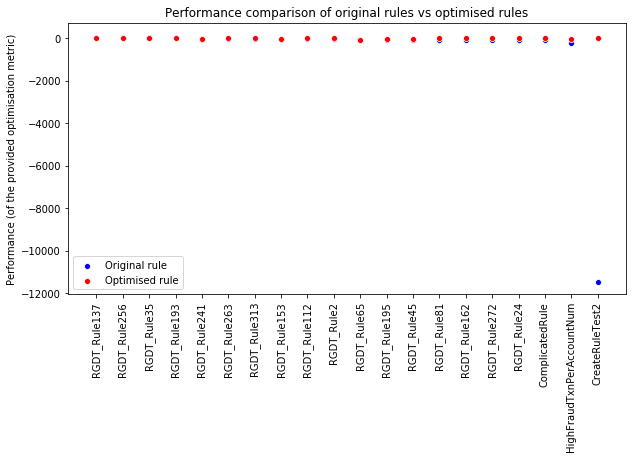

In [19]:
system_opt.plot_performance_uplift(orig_rule_performances=system_opt.orig_rule_performances,
                                   opt_rule_performances=system_opt.opt_rule_performances,
                                   figsize=(10, 5))

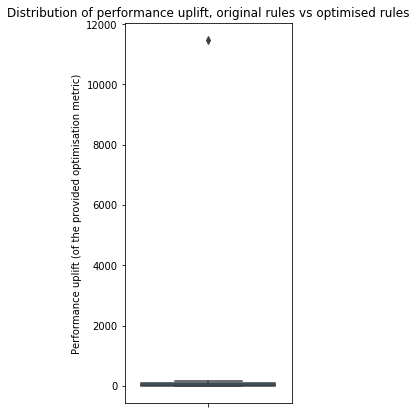

In [20]:
system_opt.plot_performance_uplift_distribution(orig_rule_performances=system_opt.orig_rule_performances,
                                                opt_rule_performances=system_opt.opt_rule_performances,
                                                figsize=(3, 7))

#### On the test set

To visualise the uplift on the test set, we first need to generate the *orig_rule_performances* and *opt_rule_performances* parameters used in the plotting methods as these aren't created as part of the optimisation process. To do this, we need to apply both the original rules and the optimised rules to the test set. **Note that before we apply the original rules, we need to remove those containing features that are missing in *X_train*:**

In [21]:
# Original rules
system_rules.filter_rules(exclude=system_opt.rule_names_missing_features)
orig_sys_rule_strings = system_rules.as_rule_strings(as_numpy=False)
orig_ra = ArgoRuleApplier(rule_strings=orig_sys_rule_strings, 
                          opt_func=apd.fit)
_ = orig_ra.apply(X=X_test)
orig_rule_performances_test = orig_ra.rule_descriptions['OptMetric']

/Users/jlaidler/venvs/argov2/lib/python3.7/site-packages/rules/convert_system_dicts_to_rule_dicts.py:79: UserWarning: JavaEL : Operator `java_el` is not currently supported in ARGO. Rule cannot be parsed.
  warnings.warn(f'{rule_name} : {e}')


In [22]:
# Optimised rules
opt_ra = ArgoRuleApplier(rule_strings=opt_rule_strings, 
                         opt_func=apd.fit)
_ = opt_ra.apply(X=X_test)
opt_rule_performances_test = opt_ra.rule_descriptions['OptMetric']

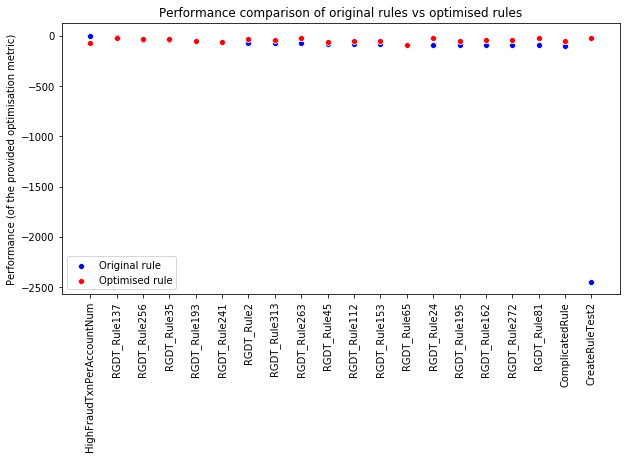

In [23]:
system_opt.plot_performance_uplift(orig_rule_performances=orig_rule_performances_test,
                                   opt_rule_performances=opt_rule_performances_test,
                                   figsize=(10, 5))

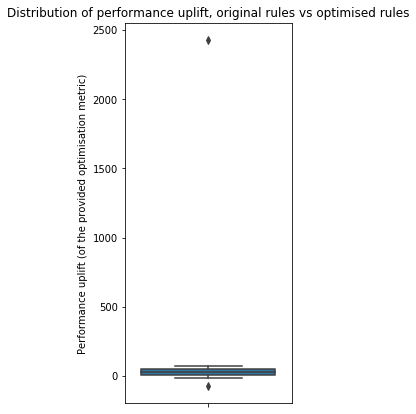

In [24]:
system_opt.plot_performance_uplift_distribution(orig_rule_performances=orig_rule_performances_test,
                                                opt_rule_performances=opt_rule_performances_test,
                                                figsize=(3, 7))

### 5. Apply the optimised rules to the dataset

Now that we have the optimised rules, we can apply them to the dataset:

In [25]:
X_rules_opt_sys_train = system_opt.apply(X=X_train)

### Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:

* rule_descriptions: A dataframe showing the logic of the optimised rules and their performance metrics as applied to the given dataset.

### 6. Get the binary columns for the un-optimised rules

For the rules which either:

1. ARGO couldn't convert into the standard ARGO lambda expression format, or; 
2. ARGO couldn't apply to the dataset due to missing features

we can use the *SimRuleApplier* class from the *rule_application* sub-package to apply these rules to a dataset and get their performance, using the *sim_ll* column:

In [26]:
rules_cannot_be_applied = system_rules.unparsed_rules + system_opt.rule_names_missing_features

In [27]:
sra = SimRuleApplier(opt_func=apd.fit, sim_ll_column='sim_ll', rules=rules_cannot_be_applied)
X_rules_unopt_sys_train = sra.apply(X=X_train)

/Users/jlaidler/venvs/argov2/lib/python3.7/site-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


### Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:

* rule_descriptions: A dataframe showing the logic of the rules and their performance metrics as applied to the given dataset.
* rules_not_in_sim_ll: List of rule names that were provided in the *rules* class constructor parameter but could not be found in the *sim_ll* column.

---

## Identify uneccessary rules <a name="CombineRules"></a>

We now have two sets of rules:

1. Optimised system rules
2. Unoptimised system rules

We can combine these rules, then apply correlation reduction and filtering methods to remove those which are unneccesary. To do this, we'll use the binary columns and the performance dataframes of the rules.

### Combine binary columns and performance dataframes of rules

In [28]:
X_rules_train = pd.concat([X_rules_opt_sys_train, X_rules_unopt_sys_train], axis=1)

In [29]:
rule_descriptions_train = pd.concat([system_opt.rule_descriptions, sra.rule_descriptions], axis=0)

In [30]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 21), (21, 4))

### Standard filter

We can use the *FilterRules* class from the *rule_filters* module to filter out rules whose performance is below a desired threshold. In this example, we'll filter out rules with a negative squared difference between the daily number of records a rule flags vs the targetted daily number of records flagged below -70. Let's first set up our filters - **note that we use the key 'OptMetric' for this metric (since this is the metric that we used to optimise the rules):**

In [31]:
filters = {
    'OptMetric': {
        'Operator': '>=',
        'Value': -70
    }
}

Now we can instantiate the *FilterRules* class and run the *fit_transform()* method to remove the rules which do not meet the filter requirements and apply the filtered rule set to the dataset:

In [32]:
fr = FilterRules(filters=filters, rule_descriptions=rule_descriptions_train)

In [33]:
X_rules_train = fr.fit_transform(X_rules=X_rules_train)

#### Outputs

The *.fit_transform()* method returns a dataframe containing the filtered rule binary columns. It also creates the following useful attributes:

- rules_to_keep (list): List of rules which remain after the filters have been applied.
- rule_descriptions (pd.DataFrame): The standard performance metrics dataframe associated with the filtered rules.

We can assign the *rule_descriptions* dataframe from the class to our variable, ensuring that the filtered rules are removed from the dataframe:

In [34]:
rule_descriptions_train = fr.rule_descriptions

In [35]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 20), (20, 4))

### Remove correlated rules

We can use the *FilterCorrelatedRules* class from the *rule_filters* module along with a correlation reduction class to remove correlated rules - see the *correlation_reduction_methods* module in the *correlation_reduction* sub-package for more information on these classes. 

In this example, we'll be using the *AgglomerativeClusteringFeatureReduction* class from that module. To instantiate this class, we also need to define a similarity function - see the *similarity_functions* module in the *correlation_reduction* sub-package for more information. In this example, we'll use the Jaccard similarity:

In [36]:
js = JaccardSimilarity()

In [37]:
acfr = AgglomerativeClusteringFeatureReduction(threshold=0.5,
                                               strategy='bottom_up', 
                                               similarity_function=js.fit, 
                                               columns_performance=rule_descriptions_train['OptMetric'])

Now we can instantiate the *FilterCorrelatedRules* class, and run the *fit_transform()* method to remove correlated rules and apply the filtered rule set to the dataset:

In [38]:
fcr = FilterCorrelatedRules(correlation_reduction_class=acfr, 
                            rule_descriptions=rule_descriptions_train)

In [39]:
X_rules_train = fcr.fit_transform(X_rules=X_rules_train)

#### Outputs

The *.fit_transform()* method returns a dataframe containing the binary columns of the uncorrelated rules. It also creates the following useful attributes:

- rules_to_keep (list): List of rules which remain after the correlation reduction has been applied.
- rule_descriptions (pd.DataFrame): The standard performance metrics dataframe associated with the uncorrelated rules.

We can assign the *rule_descriptions* dataframe from the class to our variable, ensuring that the correlated rules are removed from the dataframe:

In [40]:
rule_descriptions_train = fcr.rule_descriptions

In [41]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 14), (14, 4))

---

## Remove filtered rules from rule set <a name="RemoveFiltered"></a>

Now that we have our final rule set, we can remove the filtered rules from each of our rule set (which are saved in the *rules* attribute in our rule optimiser class):

In [42]:
final_rule_names = X_rules_train.columns.tolist()

In [43]:
system_opt.rules.filter_rules(include=final_rule_names)

We also need to remove the filtered rules from the original list of unparsed rules. To do this, we'll use a simple list comprehension:

In [44]:
final_rules_cannot_be_applied = [rule_name for rule_name in rules_cannot_be_applied if rule_name in final_rule_names]

In [45]:
len(system_opt.rules.rule_strings), len(final_rules_cannot_be_applied)

(13, 1)

---

## Test final rule set <a name="TestFinal"></a>

Now that we have our final rule set, we can apply these to the test set to ensure they perform as expected.

### Apply rules

First, we apply the rules themselves. Since we have a combination of optimised and unparsed rules, we need to apply them separately.

#### Optimised rules

Again, we apply the rules by using the *rule_strings* attribute (which correponds to the optimised rules stored in the standard ARGO-string format) from the rule optimiser class:

In [46]:
ara_opt = ArgoRuleApplier(rule_strings=system_opt.rules.rule_strings, opt_func=apd.fit)

In [47]:
X_rules_opt_test = ara_opt.apply(X_test)

#### Unoptimised rules 

In this case, we pass the list of final unparsed rules to the *SimRuleApplier* class:

In [48]:
sra = SimRuleApplier(opt_func=apd.fit, sim_ll_column='sim_ll', rules=final_rules_cannot_be_applied)

In [49]:
X_rules_unopt_sys_test = sra.apply(X=X_test)

/Users/jlaidler/venvs/argov2/lib/python3.7/site-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


#### Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:

* rule_descriptions: A dataframe showing the logic of the generated rules and their performance metrics as applied to the given dataset.

---

## Update the system-ready configs of the rules <a name="GenUpdateSysConfigs"></a>

Now that we have our final system-ready rule set, we can generate system-ready configs for the rules. How we do this depends on the type of rule:

* Optimised system rules: We use the *UpdateExistingConfigs* class from the *update_existing_configs* module in the *system_config_generation* sub-package to update the threshold values of the existing system-ready JSON configs.
* Unoptimised rules: We don't have to do anything here, since we haven't updated the thresholds of these rules.
* Inactivate system rules no longer required: We use the *UpdateExistingConfigs* class from the *update_existing_configs* module in the *system_config_generation* sub-package to update the status of the system rules that were originally active in the system, but have now been deemed unnecessary (either due to being correlated or poorly performing):

Before we can instatiate the *UpdateExistingConfigs* class, we need to get the Cassandra datatypes and field names for each pipeline output field used in the rule set. To do this, we can use the *ReturnPipelineOutputDatatypes* and *ReturnCassandraPipelineOutputMapping* classes from the *cassandra_requests* module in the *simility_requests* sub-package:

In [48]:
rpodt = ReturnPipelineOutputDatatypes(url=url,
                                      app_prefix=app_prefix,
                                      user=user,
                                      base_entity=base_entity)

In [49]:
po_dtypes = rpodt.request()

In [50]:
rcpom = ReturnCassandraPipelineOutputMapping(url=url,
                                             app_prefix=app_prefix,
                                             user=user,
                                             base_entity=base_entity)

In [51]:
cassandra_field_names = rcpom.request()

### Optimised rules

Before we can instatiate the *UpdateExistingConfigs* class, we need to get the original rule configurations from the Simility environment, so that the conditions can be updated within the configurations. To do this, we can use the *ReturnRuleConfigsFromSimility* class from the *rule_requests* module in the *simility_requests* sub-package:

In [52]:
rrcfs = ReturnRuleConfigsFromSimility(url=url,
                                      app_prefix=app_prefix,
                                      user=user,
                                      entity=base_entity,
                                      rules=system_opt.rules.rule_strings.keys()
                                     )

In [53]:
opt_rules_sys_configs = rrcfs.request()

We can use the Cassandra datatypes and field names for each pipeline output field (generated in the previous step) to convert the conditions of the optimised rules into the system-ready format:

In [54]:
final_opt_rules_sys_dicts = system_opt.rules.as_system_dicts(field_datatypes=po_dtypes, 
                                                             cassandra_field_names=cassandra_field_names)

Now that we have the original configurations and the optimised rule coniditions in the system-ready format, we can update the configurations to reflect the optimised thresholds:

In [55]:
uec = UpdateExistingConfigs(rule_configs=opt_rules_sys_configs, 
                            updated_conditions=final_opt_rules_sys_dicts)

In [56]:
final_opt_rule_configs = uec.update()

#### Outputs

The *.update()* method returns a dictionary of the updated system-ready JSON configurations for each rule. It also saves this dictionary as the class attribute *updated_rule_configs*. These configurations can be used with the *update_rules_in_simility* module in the *simility_requests* sub-package to update the provided rules in a given Simility instance.

### System rules no longer required

Before we can instatiate the *UpdateExistingConfigs* class, we need to know which system rules were in the original set that were fetched for the rule optimisation process, that are no longer in the final set of rules. To do this, we can iterate through the original rule names and check for those that aren't present in either the final optimised rule set or the final unparsed rule set:

In [57]:
sys_rules_inactivate = [rule_name for rule_name in orig_sys_conditions.keys() 
                        if rule_name not in system_opt.rules.rule_strings.keys() and rule_name not in final_rules_cannot_be_applied]

Now that we have the list of rule names we need to inactivate, we can return their original configurations:

In [58]:
rrcfs = ReturnRuleConfigsFromSimility(url=url,
                                      app_prefix=app_prefix,
                                      user=user,
                                      entity=base_entity,
                                      rules=sys_rules_inactivate
                                     )

In [59]:
sys_rules_inactivate_configs = rrcfs.request()

Finally, we can update the configurations to reflect the change in status:

In [60]:
uec = UpdateExistingConfigs(rule_configs=sys_rules_inactivate_configs, 
                            make_inactive=True)

In [61]:
final_sys_rules_inactivate_configs = uec.update()

#### Outputs

The *.update()* method returns a dictionary of the updated system-ready JSON configurations for each rule. It also saves this dictionary as the class attribute *updated_rule_configs*. These configurations can be used with the *update_rules_in_simility* module in the *simility_requests* sub-package to update the provided rules in a given Simility instance.

In [62]:
len(final_opt_rule_configs), len(final_sys_rules_inactivate_configs)

(13, 7)

---

## Update the Simility environment with the final rule set <a name="UpdateSimility"></a>

Now that we have the system-ready configurations for our optimised and inactivated rules, we can update the Simility environment with the final rule set. Note that we also need to inactivate the system rules that were originally active in the system, but have now been deemed uneccessary (either due to being correlated or poorly performing):

### Optimised rules

In [211]:
uris = UpdateRulesInSimility(url=url,
                             app_prefix=app_prefix,
                             user=user)

In [212]:
uris.request(rule_configs=final_opt_rule_configs)

### System rules no longer required

In [223]:
uris.request(rule_configs=final_sys_rules_inactivate_configs)

#### Outputs

The *.request()* method does not return a value; however, once it has ran successfully, you should see the rules have been updated in the Simility environment specified.

---

## The End

That's it folks - if you have any queries or suggestions please put them in the *#sim-datatools-help* Slack channel or email James directly.